In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from datasets import load_dataset
import fastcore.all as fc
import matplotlib.pyplot as plt
import matplotlib as mpl
import torchvision.transforms.functional as TF
from torch.utils.data import default_collate, DataLoader
import torch.optim as optim
import pickle
%matplotlib inline
plt.rcParams['figure.figsize'] = [2, 2]

In [2]:
dataset_nm = 'mnist'
x,y = 'image', 'label'
ds = load_dataset(dataset_nm)

Found cached dataset mnist (/Users/arun/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)
100%|██████████| 2/2 [00:00<00:00, 65.21it/s]


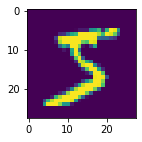

In [3]:
def transform_ds(b):
    b[x] = [TF.to_tensor(ele) for ele in b[x]]
    return b

dst = ds.with_transform(transform_ds)
plt.imshow(dst['train'][0]['image'].permute(1,2,0));

In [4]:
bs = 1024
class DataLoaders:
    def __init__(self, train_ds, valid_ds, bs, collate_fn, **kwargs):
        self.train = DataLoader(train_ds, batch_size=bs, shuffle=True, collate_fn=collate_fn, **kwargs)
        self.valid = DataLoader(train_ds, batch_size=bs*2, shuffle=False, collate_fn=collate_fn, **kwargs)

def collate_fn(b):
    collate = default_collate(b)
    return (collate[x], collate[y])

dls = DataLoaders(dst['train'], dst['test'], bs=bs, collate_fn=collate_fn)
xb,yb = next(iter(dls.train))
xb.shape, yb.shape

(torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

In [5]:
class Reshape(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, x):
        return x.reshape(self.dim)

In [6]:
def cnn_classifier():
    ks,stride = 3,2
    return nn.Sequential(
        nn.Conv2d(1, 4, kernel_size=ks, stride=stride, padding=ks//2),
        nn.ReLU(),
        nn.Conv2d(4, 8, kernel_size=ks, stride=stride, padding=ks//2),
        nn.ReLU(),
        nn.Conv2d(8, 16, kernel_size=ks, stride=stride, padding=ks//2),
        nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=ks, stride=stride, padding=ks//2),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=ks, stride=stride, padding=ks//2),
        nn.ReLU(),
        nn.Conv2d(32, 10, kernel_size=ks, stride=stride, padding=ks//2),
        nn.Flatten(),
    )

In [7]:
def linear_classifier():
    return nn.Sequential(
        Reshape((-1, 784)),
        nn.Linear(784, 50),
        nn.ReLU(),
        nn.Linear(50, 50),
        nn.ReLU(),
        nn.Linear(50, 10)
    )

In [8]:
model = linear_classifier()
lr = 0.1
max_lr = 0.1
epochs = 5
opt = optim.AdamW(model.parameters(), lr=lr)
sched = optim.lr_scheduler.OneCycleLR(opt, max_lr, total_steps=len(dls.train), epochs=epochs)

for epoch in range(epochs):
    for train in (True, False):
        accuracy = 0
        dl = dls.train if train else dls.valid
        for xb,yb in dl:
            preds = model(xb)
            loss = F.cross_entropy(preds, yb)
            if train:
                loss.backward()
                opt.step()
                opt.zero_grad()
            with torch.no_grad():
                accuracy += (preds.argmax(1).detach().cpu() == yb).float().mean()
        if train:
            sched.step()
        accuracy /= len(dl)
        print(f"{'train' if train else 'eval'}, epoch:{epoch+1}, loss: {loss.item():.4f}, accuracy: {accuracy:.4f}")
    

train, epoch:1, loss: 0.2638, accuracy: 0.8032
eval, epoch:1, loss: 0.2929, accuracy: 0.9011
train, epoch:2, loss: 0.2497, accuracy: 0.9180
eval, epoch:2, loss: 0.2317, accuracy: 0.9312
train, epoch:3, loss: 0.1817, accuracy: 0.9391
eval, epoch:3, loss: 0.1751, accuracy: 0.9496
train, epoch:4, loss: 0.1589, accuracy: 0.9518
eval, epoch:4, loss: 0.1630, accuracy: 0.9638
train, epoch:5, loss: 0.1498, accuracy: 0.9603
eval, epoch:5, loss: 0.1425, accuracy: 0.9655


In [31]:
# with open('./linear_classifier.pkl', 'wb') as model_file:
#     pickle.dump(model, model_file)

#### commit to .py file for deployment

In [33]:
!jupyter nbconvert --to script mnist.ipynb

[NbConvertApp] Converting notebook mnist.ipynb to script
[NbConvertApp] Writing 6388 bytes to mnist.py


In [ ]:
# from IPython.display import HTML, display, Image
# %%html
# <style>
#     #whiteboard {
#         border: 3px solid black;
#         border-radius: 6px;  
#         background-color: #FFFFFF;
#     }
#     #capture-button {
#         background-color: #3F52D9; 
#         color: white;
#         border: none;
#         padding: 10px 20px;
#         cursor: pointer;
#         font-size: 16px;
#         border-radius: 3px;
#         margin-top: 10px;
#         width: 190px;
#         margin-right: 20px;
#     }
#     #clear-button {
#         background-color: #FF0000,; 
#         color: black;
#         border: none;
#         padding: 10px 20px;
#         cursor: pointer;
#         font-size: 16px;
#         border-radius: 3px;
#         margin-top: 10px;
#         width: 190px;
#     }
#     #container {
#       display: flex;
#       flex-direction: column; /* Arrange children vertically */
#       align-items: center; /* Center horizontally */
#       justify-content: center;
#     }
#     #btn-container {
#       display: flex;
#       flex-direction: row; /* Arrange children vertically */
#       align-items: center; /* Center horizontally */
#     }

# </style>
# <div id='container'>
# <canvas id="whiteboard" width="400" height="200" fill_rect='white'></canvas>
# <div id='btn-container'>
# <button id="capture-button">Predict</button>
# <button id="clear-button">Clear</button>
# </div>

# </div>
# <script>
#     var canvas = document.getElementById('whiteboard');
#     var context = canvas.getContext('2d');
#     var drawing = false;
#     canvas.addEventListener('mousedown', function (e) {
#         drawing = true;
#         context.beginPath();
#         context.moveTo(e.clientX - canvas.getBoundingClientRect().left, e.clientY - canvas.getBoundingClientRect().top);
#     });
#     canvas.addEventListener('mousemove', function (e) {
#         if (drawing) {
#             context.lineTo(e.clientX - canvas.getBoundingClientRect().left, e.clientY - canvas.getBoundingClientRect().top);
#             context.stroke();
#         }
#     });
#     canvas.addEventListener('mouseup', function () {
#         drawing = false;
#     });
#     canvas.addEventListener('mouseout', function () {
#         drawing = false;
#     });
    
#     var clearButton = document.getElementById('clear-button');
#     clearButton.addEventListener('click', function () {
#        context.clearRect(0, 0, canvas.width, canvas.height);
#     });

#    var captureButton = document.getElementById('capture-button');
#     captureButton.addEventListener('click', function () {
#        // Convert the canvas content to a data URL (image)
#     var imageData = canvas.toDataURL("image/png");

#     // Send the image data to the Jupyter kernel variable
#     IPython.notebook.kernel.execute('image_data = "' + imageData + '"');
#     });
# </script>
